In [ ]:
# Librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os

# Para estadística
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro, norm

# Para aplicar MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Para separar el dataset
from sklearn.model_selection import train_test_split

# Para oversamplear datasets desbalanceados
from imblearn.over_sampling import RandomOverSampler

# Para visualización en 2d con reducción de dimensionalidad
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Para el entrenamiento de los modelos
import tensorflow as tf
from tensorflow import keras
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin

# Para no sobreentrenar
from tensorflow.keras.callbacks import EarlyStopping

# Para usar búsqueda de hiperparámetros con TensorFlow
!pip install -q keras_tuner

import keras_tuner as kt

# Métricas para evaluar
from sklearn.metrics import (classification_report, precision_recall_curve, accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score)
from sklearn.model_selection import learning_curve, cross_validate

# Visualización de los árboles de decisión
!pip install -q -U dtreeviz

import dtreeviz
from xgboost import plot_tree
import logging

# Ignorar los warning
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.2 MB/s eta 0:00:00


In [ ]:
# Fijar la semilla para garantizar reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
seed = 42

os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Tratamiento del dataset y análisis

In [ ]:
# Cargando el dataset
!wget https://raw.githubusercontent.com/plotly/datasets/502daad486f112310367a20a74a00a9cc6e75240/diabetes.csv

df = pd.read_csv('diabetes.csv')

--2024-06-05 00:06:32--  https://raw.githubusercontent.com/plotly/datasets/502daad486f112310367a20a74a00a9cc6e75240/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23873 (23K) [text/plain]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>]  23.31K  --.-KB/s    in 0s      

2024-06-05 00:06:33 (102 MB/s) - ‘diabetes.csv’ saved [23873/23873]



### Los datos representan lo siguiente
<table>
<thead>
<tr>
<th>Columna</th>
<th>Descripción</th>
<th>Unidad</th>
<th>Aclaración</th>
</tr>
</thead>
<tbody>
<tr>
<td>Pregnancies</td>
<td>Expresa el número de embarazos</td>
<td>Número natural</td>
</tr>
<tr>
<td>Glucose</td>
<td>Expresa el nivel de glucosa en sangre</td>
<td>$mg/dL$</td>
<td>Plasma glucose concentration at 2 hours in an oral glucose tolerance test</td>
</tr>
<tr>
<td>BloodPressure</td>
<td>Expresa la medición de la presión arterial</td>
<td>$mm$ $Hg$</td>
<td>Diastolic blood pressure</td>
</tr>
<tr>
<td>SkinThickness</td>
<td>Expresa el grosor de la piel</td>
<td>$mm$</td>
<td>Triceps skin fold thickness</td>
</tr>
<tr>
<td>Insulin</td>
<td>Exoresa el nivel de insulina en sangre</td>
<td>$\mu U/ml$</td>
<td>2-Hour serum insulin</td>
</tr>
<tr>
<td>BMI</td>
<td>Expresa el índice de masa corporal</td>
<td>$kg/m^2$</td>
<td>$weight/height^2$</td>
</tr>
<tr>
<td>DiabetesPedigreeFunction</td>
<td>Expresa el porcentaje de riesgo para la diabetes (basada en historial familiar)</td>
</tr>
<tr>
<td>Age</td>
<td>Expresa la edad</td>
<td>Número natural</td>
</tr>
<tr>
<td>Outcome</td>
<td>Expresa la presencia o no de diabetes</td>
<td>Únicos valores: 0 o 1</td>
<td>1 si el paciente tiene diabetes, 0 sino</td>
</tr>
</tbody>
</table>

Todos los pacientes son mujeres de al menos 21 años de herencia Pima Indian.

In [ ]:
# Primeras 5 filas
df.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

Hay valores muy grandes y muy chicos, se va a necesitar un reescalado de los mismos para algunos modelos.

In [ ]:
# Summary de los datos
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

### Hay valores que dan 0 y que no respresentan nada.

In [ ]:
# Porcentaje de la cantidad de valores 0 por columna
df.isin([0]).sum()/len(df)*100

Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                     65.104167
dtype: float64

Bastantes ceros en algunas columnas que no significa nada tenerlos. Se evaluarán más adelante medidas a tomar, por ahora se los categorizará como NaN.

In [ ]:
df[['SkinThickness','Insulin', 'BloodPressure', 'Glucose', 'BMI']] = df[['SkinThickness','Insulin',
                                                                         'BloodPressure', 'Glucose', 'BMI']].replace(0, np.nan)

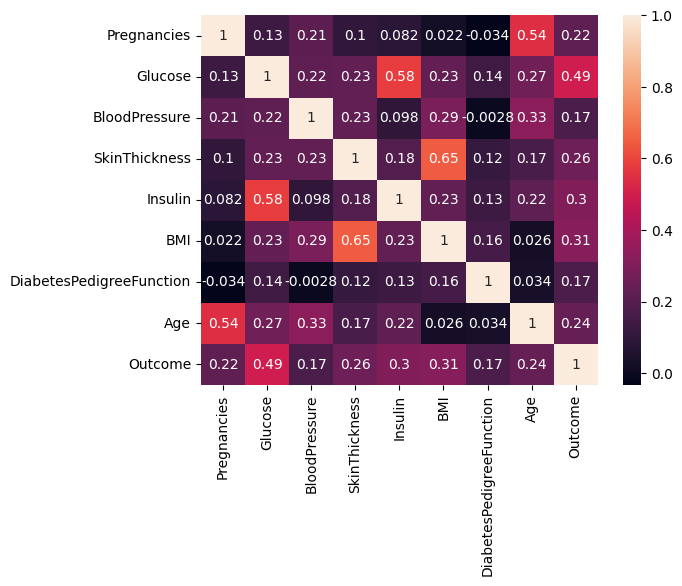

In [ ]:
# Matriz de correlación
sns.heatmap(df.corr(), annot=True)
plt.show()

Como es de esperarse, la insulina, la glucosa y el BMI son relevantes en el resultado de la diabetes. Además se perciben correlaciones considerables entre la insulina y la glucosa, SkinThickness y BMI; y edad y embarazos.

El espesor de la piel y la insulina presentan muchos valores iguales a 0, ahora categorizados como NaN, (29% y 48%, respectivamente). Considerando la importancia de estos datos se decide aplicar el método de MICE para "parchear" esos datos (más adelante se aplica). El resto de columnas se decide hacer un análisis para reemplazar estos valores por una medida de centralidad.

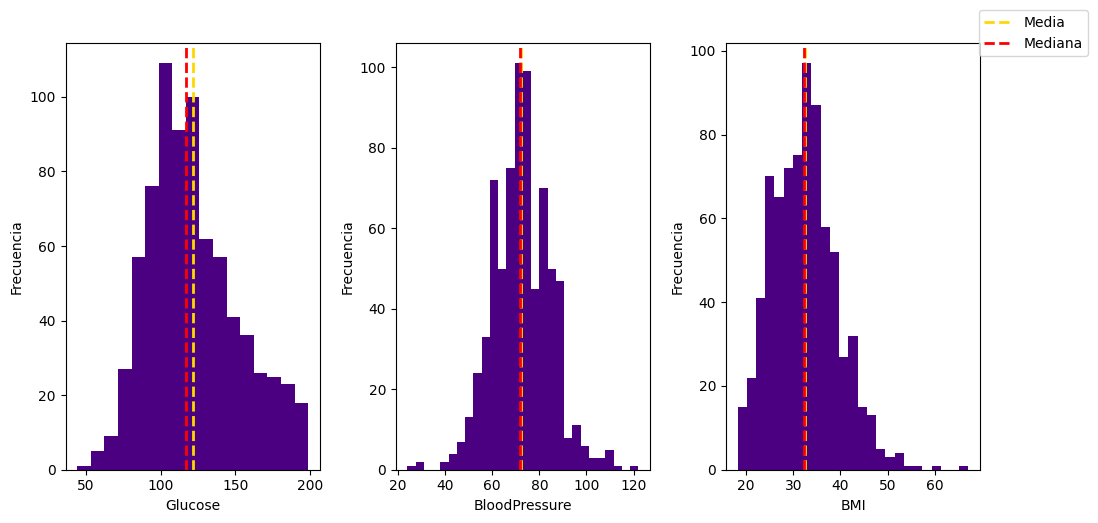

In [ ]:
# Reemplazo de valores NaN de la Glucosa, BloodPressure y BMI
columna = ['Glucose', 'BloodPressure', 'BMI']
medias, medianas = [[] for _ in range(2)]

fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)

# Histogramas para decidir si la mediana, la media o la moda representa a la muestra
for j in range(3):
  plt.subplot(1, 3, j+1)
  plt.hist(df[columna[j]], bins='auto', color='indigo')

  # Medidas de centralidad
  media = df[columna[j]].mean()
  mediana = df[columna[j]].median()
  # Se agregan a sus respectivas listas
  medias.append(media)
  medianas.append(mediana)

  # Ploteo
  plt.xlabel(columna[j])
  plt.ylabel('Frecuencia')
  plt.axvline(x = media, color = 'gold', linestyle='--', linewidth=2)
  plt.axvline(x = mediana, color = 'r', linestyle='--', linewidth=2)

# Leyenda
fig.legend(bbox_to_anchor=(1.1, 1.05), labels=['Media','Mediana'])
plt.tight_layout()
plt.show()

En base a esto se propone cambiar los valores NaN por:
<table>
<thead>
<tr>
<th>Columna</th>
<th>Reemplazo por</th>
</tr>
</thead>
<tbody>
<tr>
<td>Glucose</td>
<td>Mediana</td>
</tr>
<tr>
<td>BloodPressure</td>
<td>Mediana</td>
</tr>
<tr>
<td>BMI</td>
<td>Mediana</td>
</tr>
</tbody>
</table>

In [ ]:
# Reemplazo de dichos valores
reemplazos = {'Glucose': medianas[0], 'BloodPressure': medianas[1],'BMI': medianas[2]}
df.replace(np.nan, reemplazos, inplace=True)

In [ ]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     541.000000  394.000000   
mean      3.845052  121.656250      72.386719      29.153420  155.548223   
std       3.369578   30.438286      12.096642      10.476982  118.775855   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      22.000000   76.250000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      36.000000  190.000000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.348958  
std      6.875177                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.300000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

Veamos los boxplots en búsqueda de ver si no hay cosas raras.

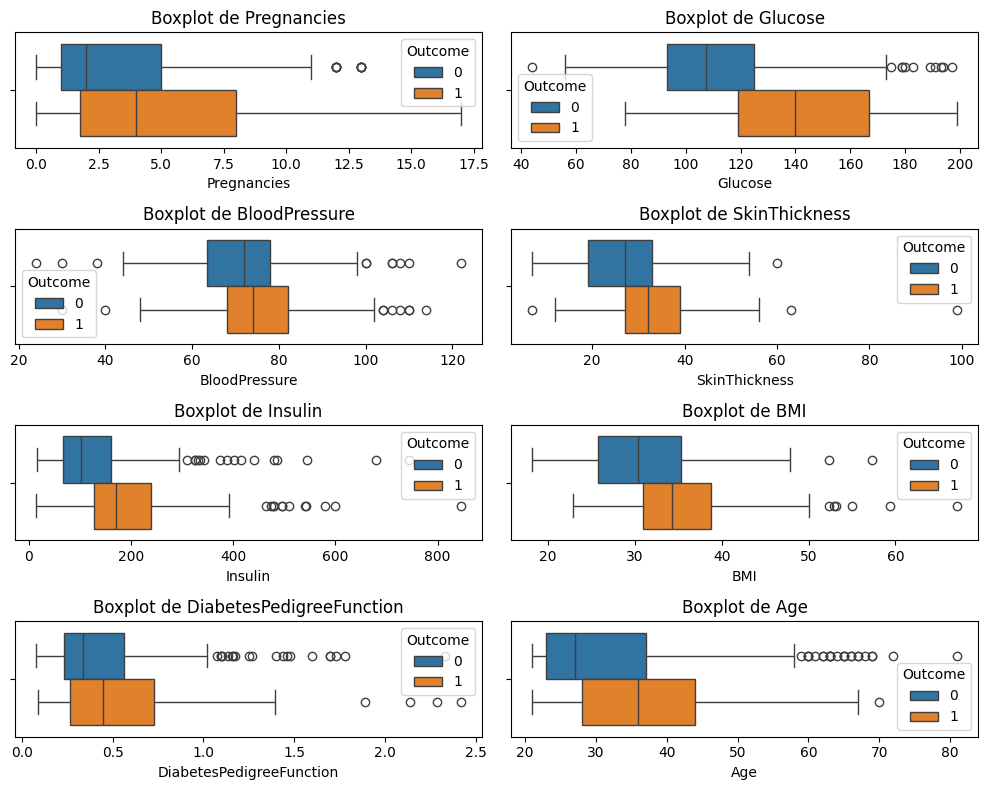

In [ ]:
plt.figure(figsize=(10, 8))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(data=df, x=column, hue='Outcome')
    plt.title(f'Boxplot de {column}')
plt.tight_layout()
plt.show()

Se considera que una SkinThickness de casi 100mm no es posible y valores de insulina arriba de 600 son poco probables. Por ello se decide eliminar estos datos.

In [ ]:
df.drop(df[(df['Insulin'] > 600) | (df['SkinThickness'] > 90)].index, inplace=True)

La decisión de no seguir sacando posibles outliers viene dada por considerar que hace falta información del tipo y técnicas del muestro. Así mismo como una comprensión más profunda (con un experto en el área de la medicina) de los tipos de datos para poder evaluar qué es outlier y qué no.

## Porcentaje de diabéticos

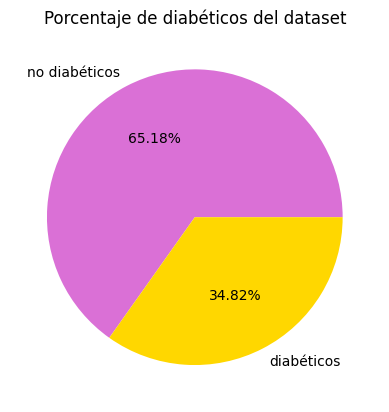

In [ ]:
plt.pie(df['Outcome'].value_counts(), labels=['no diabéticos','diabéticos'], autopct='%1.2f%%', colors=['orchid', 'gold'])
plt.title(label="Porcentaje de diabéticos del dataset")
plt.show()

Queremos un modelo que supere ampliamente el 65% de accuracy, sino sería un modelo que no aporta nada.

## ¿La glucosa tiene una distribución normal?

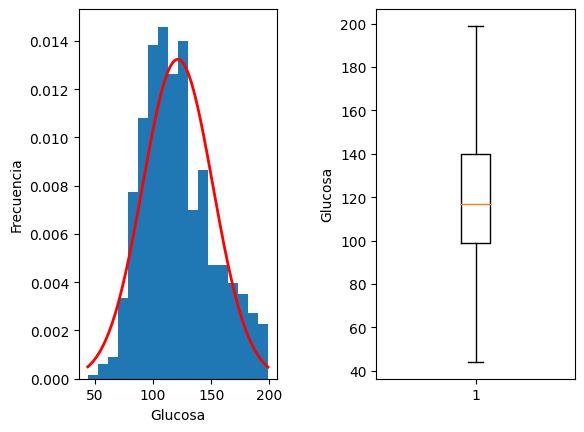

In [ ]:
# Veamos un histograma y boxplot
fig = plt.figure()
fig.subplots_adjust(hspace=0.3, wspace=0.5)

plt.subplot(1, 2, 1)
plt.hist(df['Glucose'], bins='auto', density=True)
x_axis = np.arange(df.Glucose.min(), df.Glucose.max(), 0.1)
plt.plot(x_axis, norm.pdf(x_axis, df.Glucose.mean(), df.Glucose.std()), linewidth=2, color='r')
plt.xlabel('Glucosa')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.boxplot(df['Glucose'])
plt.ylabel('Glucosa')

plt.show()

El histograma da con una cola más pesada a izquierda (cae más rápidamente). <br>

Por otro lado, el boxplot da un resultado un poco asimétrico, la mediana no queda tan centrado como debería.
Pros: los brazos son parecidos.

Figure(640x480)


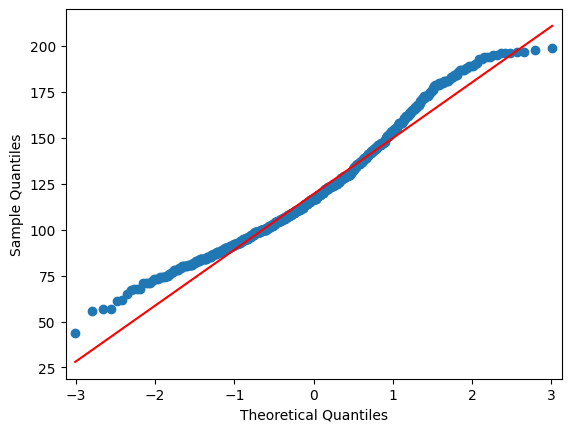

In [ ]:
# Haré un qqplot
print(sm.qqplot(df['Glucose'], line='q'))

Efectivamente, se tiene una cola pesada a izquierda y liviana a derecha (aunque abrupta). Podríamos concluir que la glucosa no tiene una distribución normal.

Veamos un test de hipótesis para corroborar que no tiene una distribución normal.

In [ ]:
# Shapiro-Wilk test para ver si corresponde a una distribución normal
shapiro(df['Glucose'])

ShapiroResult(statistic=0.9708461165428162, pvalue=3.278694676867033e-11)

El p-valor es muy chiquito, para cualquier nivel de significación aceptable se rechazaría la hipótesis nula de que la distrubición de la glucosa es normal.

Sin embargo, separando por diabéticos y no diabéticos se tiene una distribución más normal:

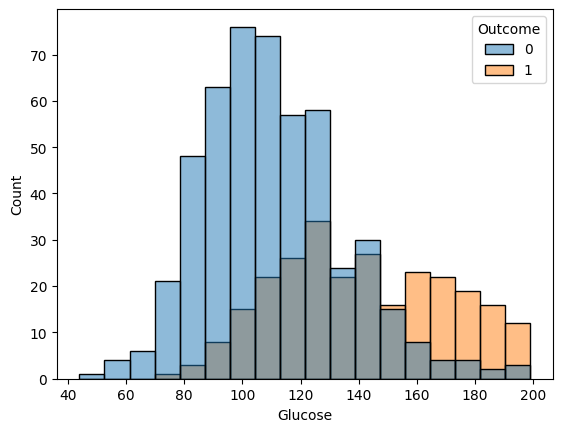

In [ ]:
sns.histplot(data=df,x='Glucose',hue='Outcome')
plt.show()

In [ ]:
# Test de normalidad
print('test de Shapiro en las personas NO diabéticas: \n p-valor =', shapiro(df.loc[df["Outcome"] == 0, "Glucose"])[1])
print('test de Shapiro en las personas diabéticas: \n p-valor =', shapiro(df.loc[df["Outcome"] == 1, "Glucose"])[1])

test de Shapiro en las personas NO diabéticas: 
 p-valor = 7.031084692243894e-07
test de Shapiro en las personas diabéticas: 
 p-valor = 0.0001186119407066144


Volviendo a hacer el Shapiro-Wilk test obtenemos un resultado mejor pero aún así no se tiene normalidad para un nivel de significación razonable.

##¿Cuál es el máximo número de embarazos?

In [ ]:
df['Pregnancies'].max()

17

¡Una mujer tuvo 17 embarazos! ¿Es posible? Veamos su edad:

In [ ]:
df[df['Pregnancies']==df['Pregnancies'].max()]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
159           17    163.0           72.0           41.0    114.0  40.9   

     DiabetesPedigreeFunction  Age  Outcome  
159                     0.817   47        1

La edad no nos descarta la posibilidad de 17 embarazos. Se decide mantener el dato.

## ¿La presión arterial tiene una distribución normal?

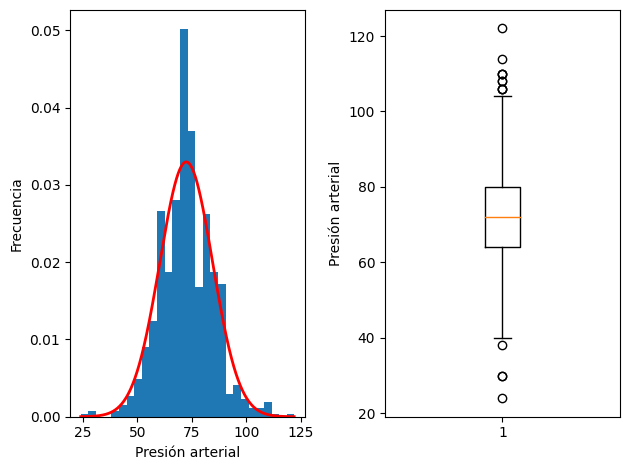

In [ ]:
# Veamos un histograma
plt.subplot(1, 2, 1)
plt.hist(df['BloodPressure'], bins='auto', density=True)

# Ploteo de una normal usando la media y desvío de la BloodPressure
x_axis = np.arange(df.BloodPressure.min(), df.BloodPressure.max(), 0.1)
plt.plot(x_axis, norm.pdf(x_axis, df.BloodPressure.mean(), df.BloodPressure.std()), linewidth=2, color='r')

# Etiquetas
plt.xlabel('Presión arterial')
plt.ylabel('Frecuencia')

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(df['BloodPressure'])
plt.ylabel('Presión arterial')
plt.tight_layout()
plt.show()

Tiene un compartamiento nada parecido a la de una normal, con muchos datos atípicos.

In [ ]:
# Rango intercuartil
IQR = stats.iqr(df['BloodPressure'])
print(IQR)

16.0


Comrpobando con el test de Shapiro-Wilk:

In [ ]:
# Test de normalidad
print(shapiro(df['BloodPressure']))

ShapiroResult(statistic=0.9878081679344177, pvalue=5.525813776330324e-06)


Se concluye que los datos no vienen de una distribución normal.

## Dispersión de los datos para descubrir patrones

Veamos la dispersión de los datos separados por diabéticos y no diabéticos:

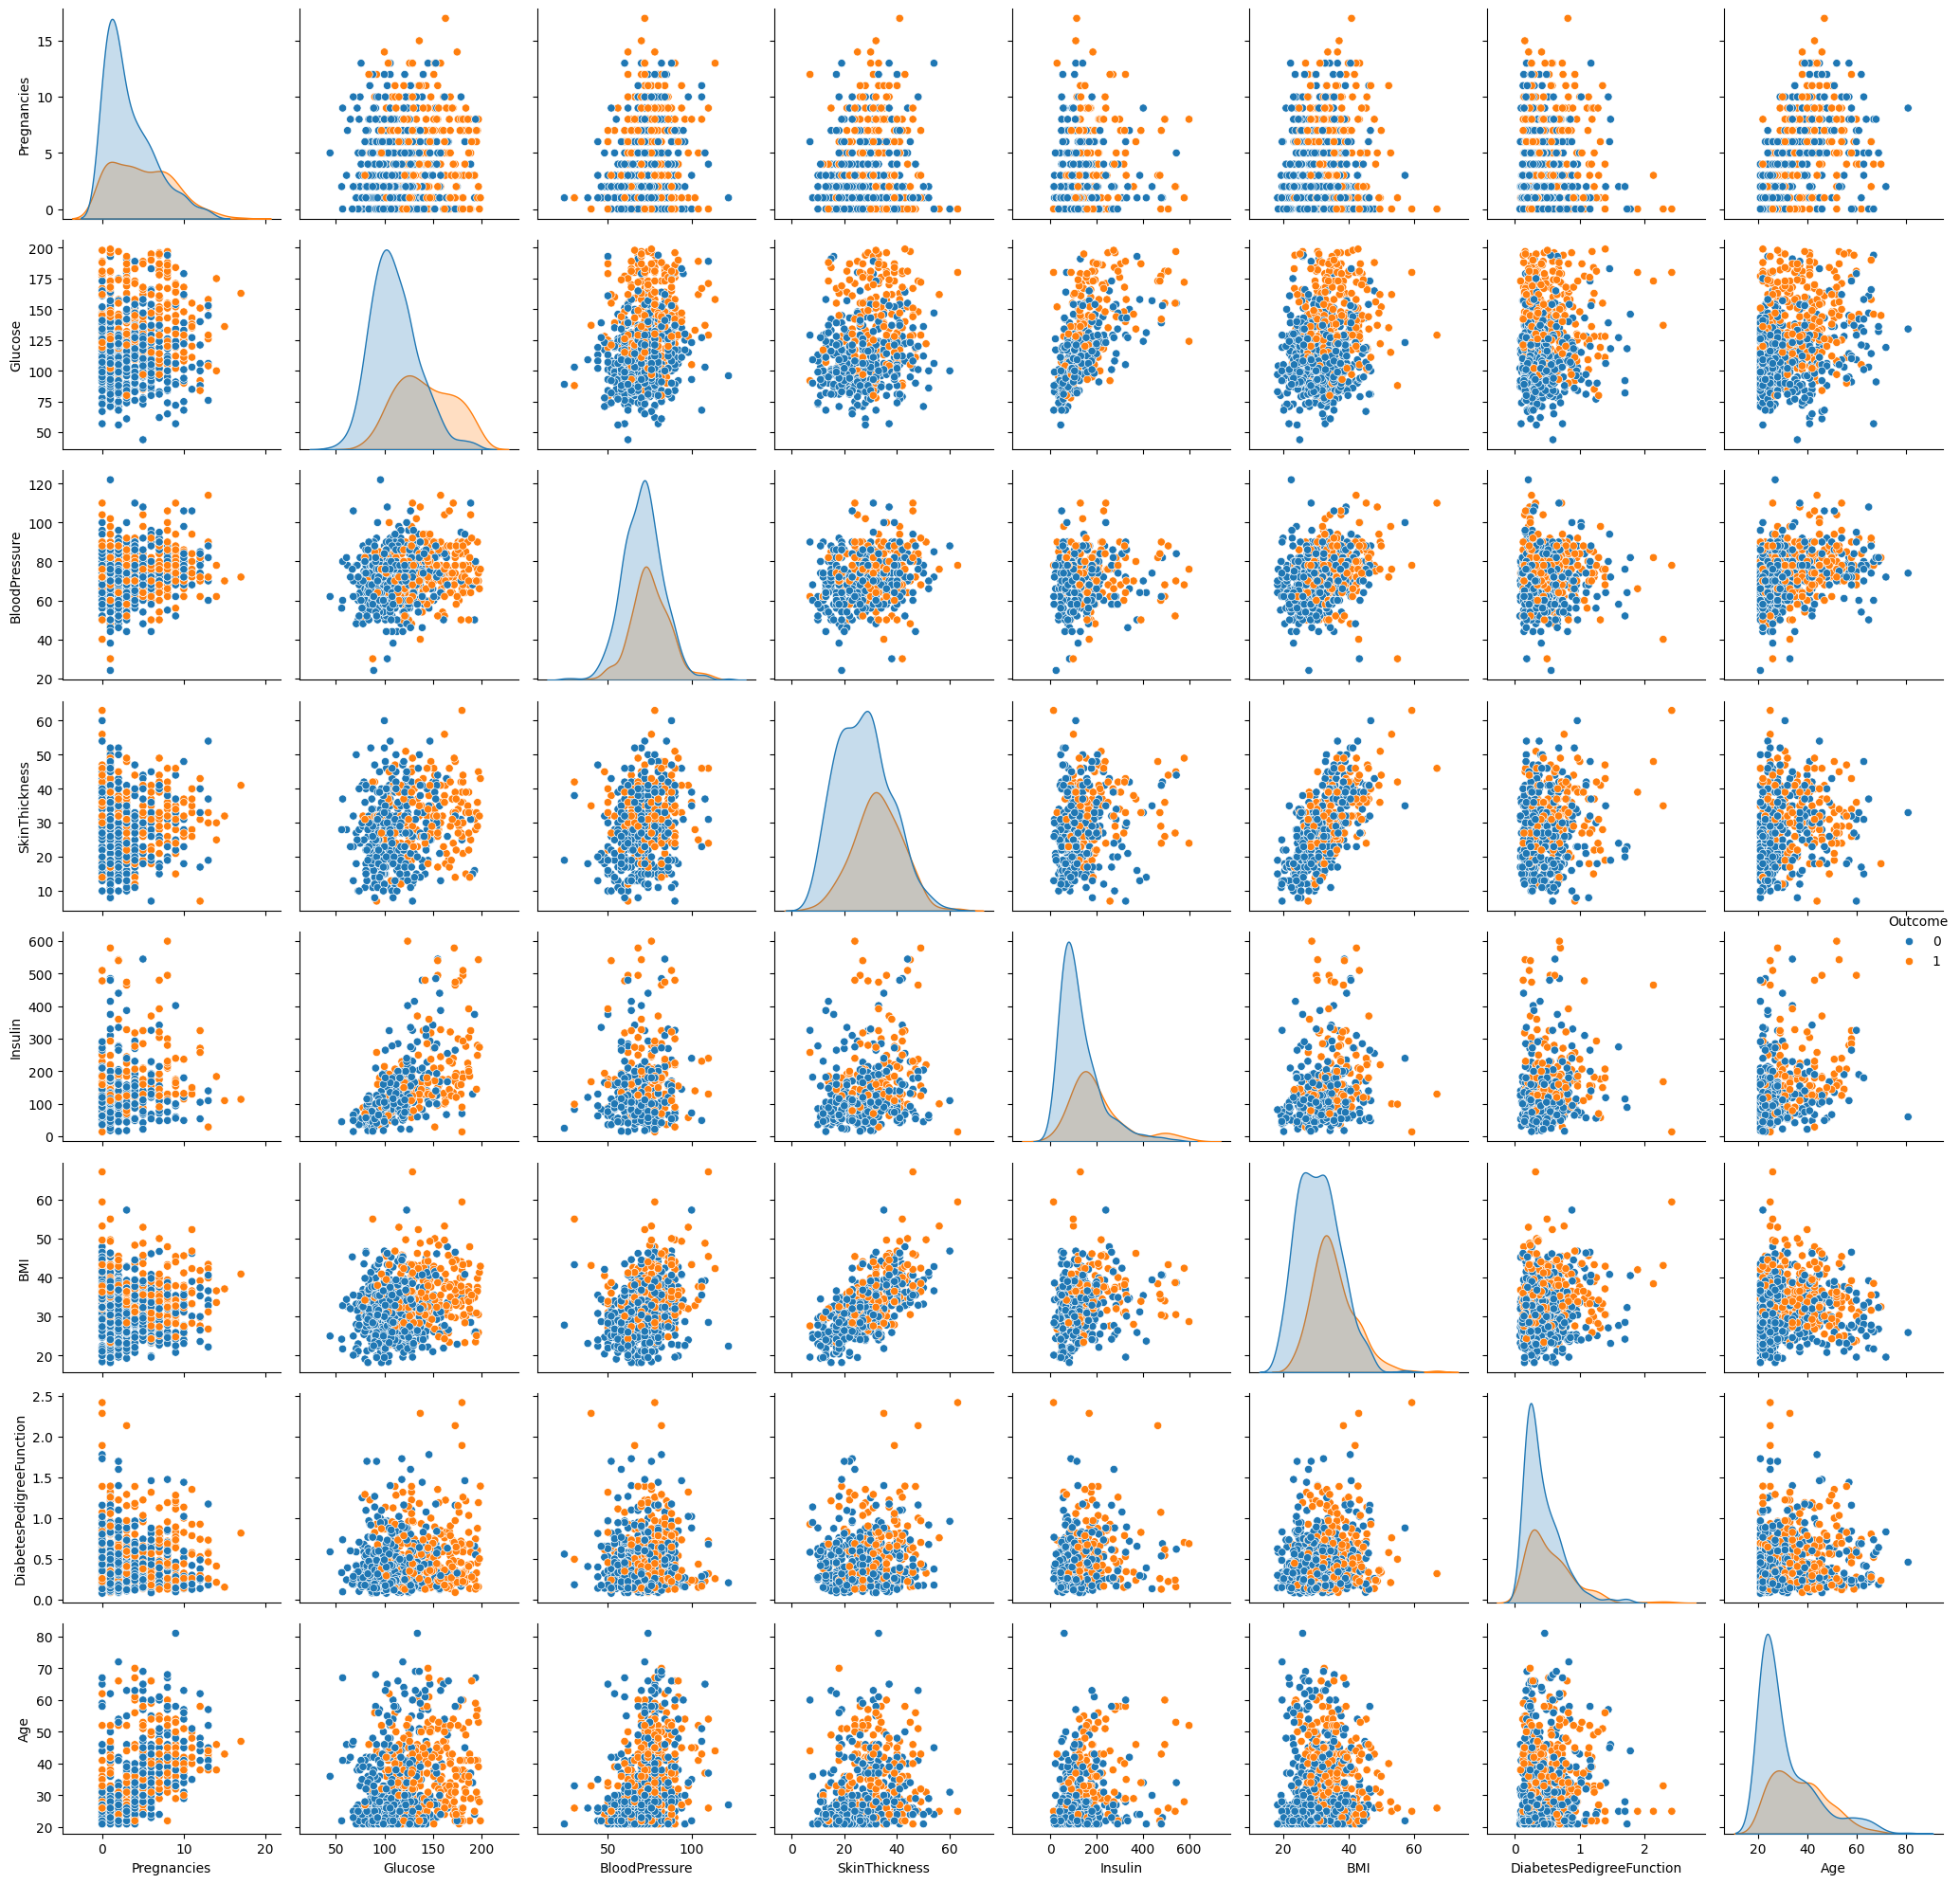

In [ ]:
sns.pairplot(df, hue='Outcome')
plt.tight_layout()
plt.show()

Se ve la tendencia clara que a mayor nivel de Glucosa más tendencia a ser diabético. Con el BMI y la Glucosa los sets de diabéticos y no diabéticos se notan un poco más definidos.

# Última etapa del preprocesamiento

In [ ]:
train_data = df.copy()
train_label = train_data.pop('Outcome')

Mantendremos la proporcionalidad (de diabético y no diabéticos) en los distintos conjuntos. Por eso se usa stratify.

In [ ]:
# Se separa los datos en 3 pares de sets: training, validation data y test
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, train_size = .8, shuffle=True,
                                                    random_state=seed, stratify=train_label)

X_train, X_val, y_train, y_val = train_test_split(X_train,  y_train, train_size = .8, shuffle=True,
                                                 random_state=seed, stratify=y_train)

training_complete = pd.concat([X_train, y_train], axis=1)

## Método Mice al conjunto de entrenamiento

Se lo va a aplicar sólo al conjunto de entrenamiento, en el resto de conjuntos se van a eliminar los datos NaN.

In [ ]:
# Eliminación de datos NaN en los conjuntos de testeo y validación
na_indices_test = X_test[X_test.isna().any(axis=1)].index
X_test.dropna(inplace=True)
y_test.drop(index=na_indices_test, inplace=True)

na_indices_val = X_val[X_val.isna().any(axis=1)].index
X_val.dropna(inplace=True)
y_val.drop(index=na_indices_val, inplace=True)

In [ ]:
# Aplicar IterativeImputer (MICE)
imputer = IterativeImputer(max_iter=10, random_state=seed)
imputed_data = imputer.fit_transform(training_complete)
training_complete = pd.DataFrame(imputed_data, columns=training_complete.columns)

Chequeemos que los datos fueron asignados acorde.

In [ ]:
X_train.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   488.000000  488.000000     488.000000     340.000000  249.000000   
mean      3.901639  121.823770      72.274590      29.738235  151.867470   
std       3.395636   29.656377      12.167314       9.890209  108.783942   
min       0.000000   56.000000      24.000000       8.000000   14.000000   
25%       1.000000  100.000000      64.000000      22.000000   76.000000   
50%       3.000000  118.000000      72.000000      30.000000  125.000000   
75%       6.000000  140.250000      80.000000      37.000000  190.000000   
max      17.000000  197.000000     122.000000      63.000000  545.000000   

              BMI  DiabetesPedigreeFunction         Age  
count  488.000000                488.000000  488.000000  
mean    32.842418                  0.462951   32.879098  
std      7.003814                  0.316859   11.409844  
min     18.200000                  0.084000   21.000000  
25%     27.875000                  0.244000   24.000000  
50%     32.450000                  0.370000   29.000000  
75%     36.975000                  0.624750   39.250000  
max     67.100000                  2.420000   81.000000

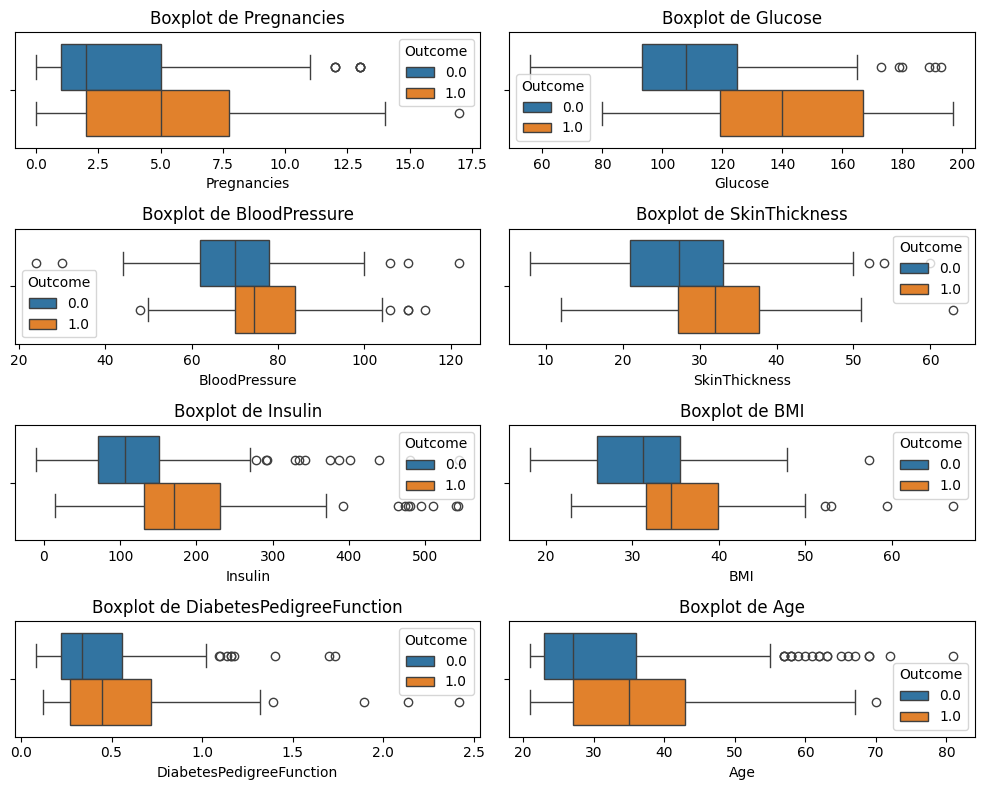

In [ ]:
plt.figure(figsize=(10, 8))
for i, column in enumerate(X_train.columns):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(data=training_complete, x=column, hue='Outcome')
    plt.title(f'Boxplot de {column}')
plt.tight_layout()
plt.show()

In [ ]:
y_train_sin_oversampling = training_complete.pop('Outcome')
X_train_sin_oversampling = training_complete

## Oversampling al conjunto de entrenamiento

Tratemos de equilibrar las clases de diabéticos y no diabéticos. Para ello haremos un bootstrap en la clase de diabéticos SOLO para el conjunto de entrenamiento. Habrá más riesgo de sobrefiteo.

In [ ]:
ros = RandomOverSampler(random_state=seed)
X_train, y_train = ros.fit_resample(X_train_sin_oversampling, y_train_sin_oversampling)

## Disminución de la dimensionalidad en busca de patrones (sólo para visualizar)

La varianza explicada es de: [0.92115587 0.04361261]


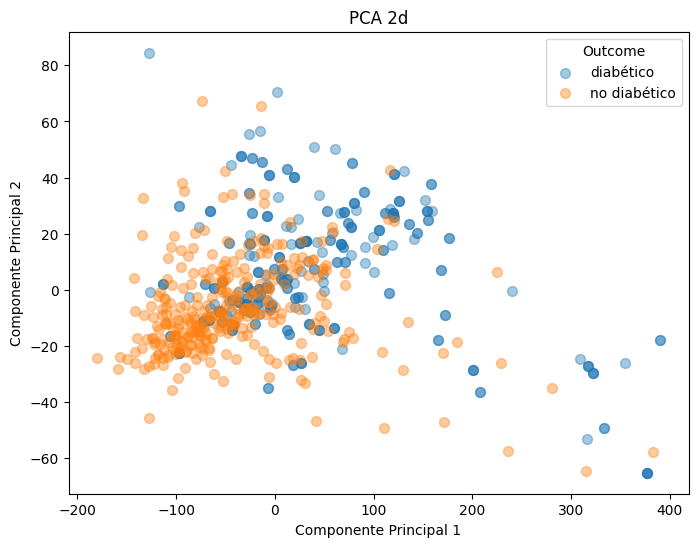

In [ ]:
# Aplicar PCA para reducir a 2 dimensiones
pca_2d = PCA(n_components=2)
components_2d = pca_2d.fit_transform(X_train)

# Visualización
plt.figure(figsize=(8, 6))
outcome_texto = {0: 'no diabético', 1:'diabético'}
for outcome in y_train.unique():
    subset = components_2d[y_train == outcome]
    plt.scatter(subset[:, 0], subset[:, 1], label=outcome_texto[outcome], s=50, alpha=0.4)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA 2d')
plt.legend(title='Outcome')
print('La varianza explicada es de:', pca_2d.explained_variance_ratio_)
plt.show()

Muy buena varianza explicada, arriba del 96%. Se puede llegar a ver secciones en las que predominan mayormente los no diabéticos.

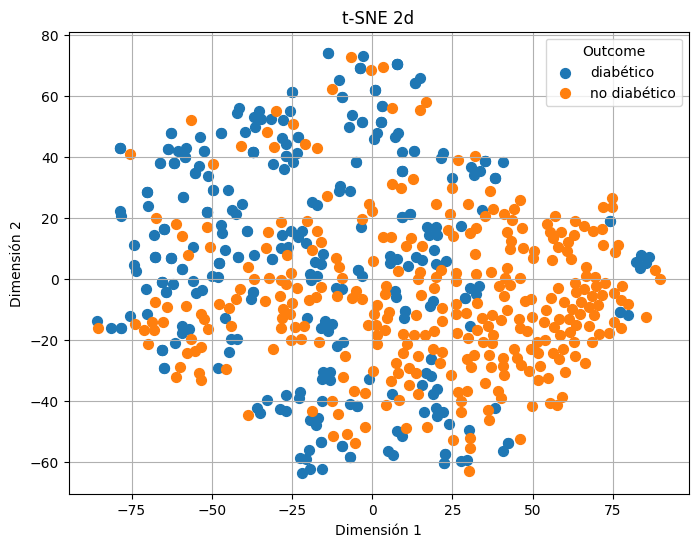

In [ ]:
# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=seed)
components_tsne = tsne.fit_transform(scaled_data)

# Visualización
plt.figure(figsize=(8, 6))
outcome_texto = {0: 'no diabético', 1:'diabético'}
for outcome in y_train.unique():
    subset = components_tsne[y_train == outcome]
    plt.scatter(subset[:, 0], subset[:, 1], label=outcome_texto[outcome], s=50)
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.title('t-SNE 2d')
plt.legend(title='Outcome')
plt.grid()
plt.show()

t-SNE reduce dimensionalidad mientras trata de mantener distancias cercanas entre los datos que se aproximan y distancias más largas entre los datos que no se aproximan.<br>
Se ven los sectores de diabéticos y no diabéticos más diferenciados así, principalmente el sector no diabético.

Aclaración: es preferible tener mayor recall (poder clasificar bien a la gente que está enferma) por ello se ajustará al threshold adecuado para cada modelo.

# Usando redes neuronales

## Reescalado de valores

In [ ]:
Scaler = StandardScaler()

Scaler.fit(X_train)
X_train_escalado = Scaler.transform(X_train)
X_val_escalado = Scaler.transform(X_val)
X_test_escalado = Scaler.transform(X_test)

## Búsqueda en grilla para hallar el mejor modelo de red neuronal

In [ ]:
custom_threshold = 0.5
def model_builder(hp):
  # Número de neuronas en la primera y segunda capa
  hp_units_1 = hp.Int('units_1', min_value=32, max_value=152, step=32)
  hp_units_2 = hp.Int('units_2', min_value=32, max_value=152, step=32)

  model = keras.Sequential([
      keras.layers.Dense(hp_units_1, input_shape=[X_train.shape[1],], activation='relu'),
      keras.layers.Dropout(0.2),
      # Para normalizar las activaciones
      keras.layers.BatchNormalization(),
      keras.layers.Dense(hp_units_2, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Variación del learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", dtype=None, threshold=custom_threshold),
                         tf.keras.metrics.Precision(thresholds=custom_threshold, name='precision'),
                         tf.keras.metrics.Recall(thresholds=custom_threshold, name='recall'),
                         tf.keras.metrics.AUC(name='auc')]
              )

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     seed=seed)

# Vamos a ponerle un stop para no sobre-entrenar, que pare cuando la val_loss no siga bajando
patience = 5
stop_early = tf.keras.callbacks.EarlyStopping(
    start_from_epoch=2, # dejar correr al menos 2 épocas
    min_delta=0.001, # mínima cantidad que cuenta como mejora
    patience=patience, # épocas antes de parar
    restore_best_weights=True # se queda con los mejores pesos antes de no decrecer más
)

In [ ]:
# Búsqueda de los mejores hiperparámetros
tuner.search(X_train_escalado, y_train, epochs=50, validation_data=(X_val_escalado, y_val), callbacks=[stop_early])

# Hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
El número óptimo de neuronas en la primera capa es de {best_hps.get('units_1')}.
El número óptimo de neuronas en la segunda capa es de {best_hps.get('units_2')}.
El learning rate óptimo es {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 05s]
val_auc: 0.8888888359069824

Best val_auc So Far: 0.9284721612930298
Total elapsed time: 00h 02m 00s

El número óptimo de neuronas en la primera capa es de 32.
El número óptimo de neuronas en la segunda capa es de 96.
El learning rate óptimo es 0.01.



## Entreno la mejor red

In [ ]:
# Esta clase servirá para el modelo de Ensemble, por eso se aplica ahora
class TFNeuralNetwork(BaseEstimator, ClassifierMixin):
    def __init__(self, input_shape, threshold=0.5):
        self.input_shape = input_shape
        self.model = self._build_model()
        self.threshold = threshold
        self.history = None
        self.callbacks = [stop_early]

    def _build_model(self):
        model = tuner.hypermodel.build(best_hps)
        return model

    def fit(self, X, y, batch_size=200, epochs=80, verbose=0, *args, **kwargs):
        self.history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=self.callbacks, *args, **kwargs)
        return self.history

    def predict(self, X):
        pred_probs = self.model.predict(X, verbose=0)
        return (pred_probs > self.threshold).astype("int32")

    def predict_proba(self, X):
        pred_probs = self.model.predict(X, verbose=0)
        return np.hstack([1 - pred_probs, pred_probs])

In [ ]:
model_red_neuronal = TFNeuralNetwork(input_shape=(X_train.shape[1],), threshold=custom_threshold)

In [ ]:
# Entreno el modelo, ya tiene el callback asignado
history = model_red_neuronal.fit(X_train_escalado, y_train, batch_size=200, epochs=70,
                                 validation_data=(X_val_escalado, y_val), verbose=1)

Epoch 1/70
4/4 [==============================] - 2s 147ms/step - loss: 0.6736 - accuracy: 0.6619 - precision: 0.6656 - recall: 0.6509 - auc: 0.7250 - val_loss: 0.5436 - val_accuracy: 0.7143 - val_precision: 0.5769 - val_recall: 0.7500 - val_auc: 0.8563
Epoch 2/70
4/4 [==============================] - 0s 23ms/step - loss: 0.5615 - accuracy: 0.7311 - precision: 0.7394 - recall: 0.7138 - auc: 0.8097 - val_loss: 0.5526 - val_accuracy: 0.7679 - val_precision: 0.6667 - val_recall: 0.7000 - val_auc: 0.8778
Epoch 3/70
4/4 [==============================] - 0s 27ms/step - loss: 0.5500 - accuracy: 0.7154 - precision: 0.7338 - recall: 0.6761 - auc: 0.8092 - val_loss: 0.5571 - val_accuracy: 0.7857 - val_precision: 0.6818 - val_recall: 0.7500 - val_auc: 0.8764
Epoch 4/70
4/4 [==============================] - 0s 23ms/step - loss: 0.4822 - accuracy: 0.7610 - precision: 0.7677 - recall: 0.7484 - auc: 0.8477 - val_loss: 0.5594 - val_accuracy: 0.7679 - val_precision: 0.6296 - val_recall: 0.8500 - val

Última Validation Loss: 0.4403 
Última Validation Accuracy: 0.7857 
Última Validation Precision: 0.7500 
Última Validation Recall: 0.6000


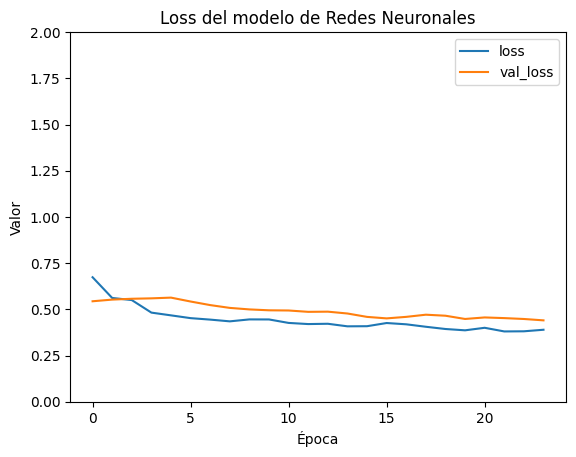

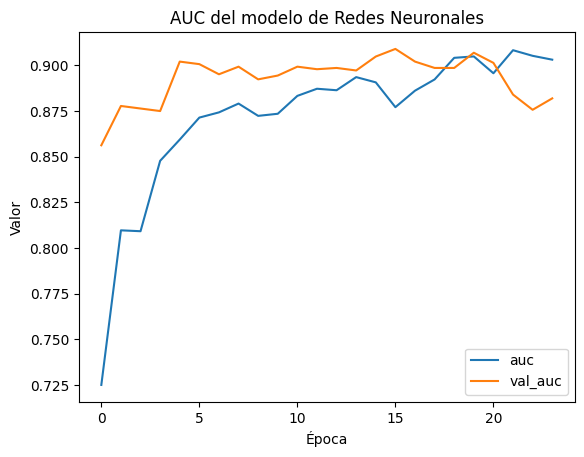

In [ ]:
# Ploteo de la loss y el auc
history_df = pd.DataFrame(history.history)[:-patience]
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title('Loss del modelo de Redes Neuronales')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.ylim((0,2))
history_df.loc[:, ['auc', 'val_auc']].plot()
plt.title('AUC del modelo de Redes Neuronales')
plt.xlabel('Época')
plt.ylabel('Valor')

print(("Última Validation Loss: {:0.4f} \n" +\
      "Última Validation Accuracy: {:0.4f} \n" +\
      "Última Validation Precision: {:0.4f} \n" +\
      "Última Validation Recall: {:0.4f}") \
      .format(history_df["val_loss"].iloc[-1],
              history_df["val_accuracy"].iloc[-1],
              history_df["val_precision"].iloc[-1],
              history_df["val_recall"].iloc[-1]))

No parece haber overfitting ni underfitting.

## Elección del threshold

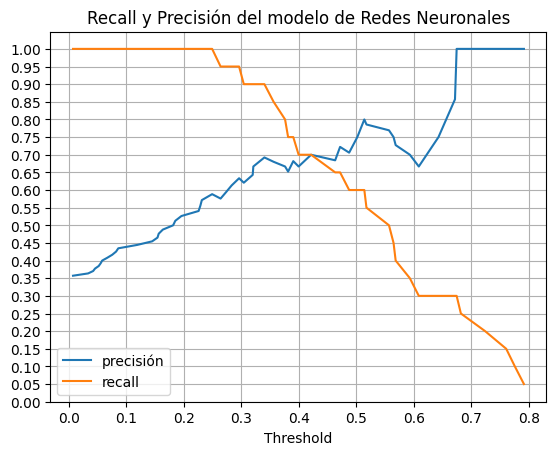

In [ ]:
# Ploteo de la recall y precisión en base al threshold
prob = model_red_neuronal.predict_proba(X_val_escalado)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, prob)  # Se le pueden pasar probabilidades
plt.plot(thresholds, precision[:-1], label='precisión')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.yticks(np.linspace(0, 1, num=21))
plt.title('Recall y Precisión del modelo de Redes Neuronales')
plt.show()

Viendo el gráfico hay un punto que tiene una buena recall (de 0.9) y buena precision (alrededor de 0.7). Averiguemos qué punto es:

In [ ]:
# Se define una recall mínima que se quiere y de ahí se saca el threshold
recall_min = 0.9
custom_threshold = thresholds[np.argmin(recall >= recall_min)]
print(f'El threshold elegido es de: {custom_threshold:.2f} \n')

El threshold elegido es de: 0.36 



## Curva ROC

El área de la curva ROC es 0.8819444444444445


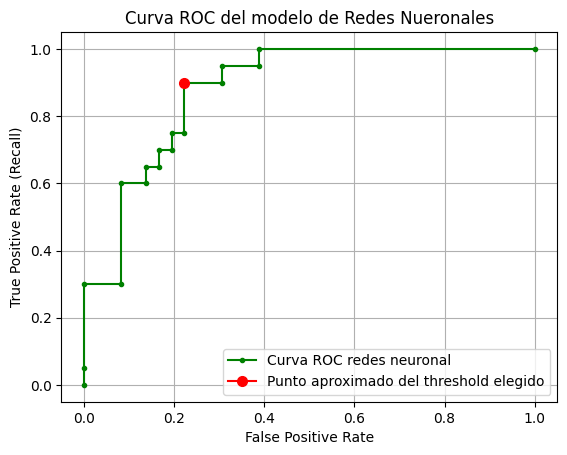

In [ ]:
fper, tper, thresholds = roc_curve(y_val, prob)  # Se le pueden pasar probabilidades
roc_auc = roc_auc_score(y_val, prob)
plt.plot(fper, tper, marker='.', label='Curva ROC redes neuronal',color='g')
plt.plot(fper[np.argmax(thresholds < custom_threshold)],
         tper[np.argmax(thresholds < custom_threshold)], marker='o', markersize=7,
         color='r', label='Punto aproximado del threshold elegido')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid()
print('El área de la curva ROC es',roc_auc)
plt.title('Curva ROC del modelo de Redes Nueronales')
plt.show()

## Evaluación del modelo en el conjunto de testeo

In [ ]:
# Realizar predicciones en los datos de prueba
pred_probabilities = model_red_neuronal.predict_proba(X_test_escalado)[:,1]

# Convertir probabilidades en etiquetas utilizando el umbral personalizado
pred_labels_custom_threshold = (pred_probabilities >= custom_threshold).astype(int)

print('Métricas en el conjunto de testeo:\n', classification_report(y_test, pred_labels_custom_threshold))

Métricas en el conjunto de testeo:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        54
           1       0.68      0.78      0.72        32

    accuracy                           0.78        86
   macro avg       0.77      0.78      0.77        86
weighted avg       0.79      0.78      0.78        86



Se obtuvo buena recall a costa de una baja en la precisión (en la clase diabética). Buena recall y precisión en la clase no diabética.

## Veamos la matriz de confusión

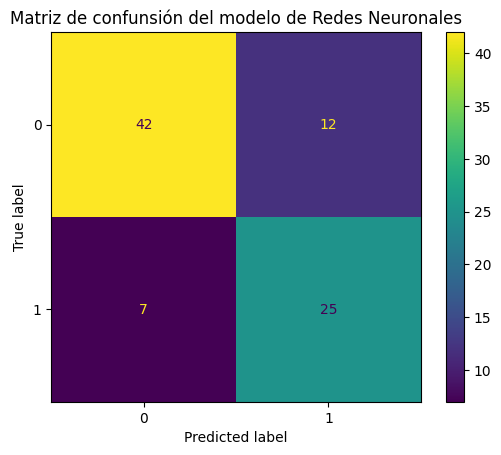

In [ ]:
predicted = model_red_neuronal.predict_proba(X_test_escalado)[:,1]
predicted = (predicted > custom_threshold).astype('int')
cm = confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.title('Matriz de confunsión del modelo de Redes Neuronales')
plt.show()

# Usando Boosting

In [ ]:
# Definir el grid para búsqueda por grilla
param_grid = {
    'n_estimators': [4, 10, 15],  # Número de árboles en el ensamble
    'max_depth': [2, 3],        # Profundidad máxima de cada árbol
    'learning_rate': [0.2, 0.3, 0.35, 0.4],  # Tasa de aprendizaje
    'gamma': [1, 1.5, 2, 2.5],          # Parámetro de regularización que controla la complejidad del árbol
    'reg_alpha': [0.3, 0.5, 1, 2],        # Término de regularización L1 (Lasso)
    'reg_lambda': [0.15, 0.2, 0.3, 0.5],       # Término de regularización L2 (Ridge)
}

# Configurar GridSearchCV
grid_search_boosting = GridSearchCV(estimator=XGBClassifier(random_state=seed, n_jobs=-1),
                           param_grid=param_grid, scoring='roc_auc', cv=7, n_jobs=-1)

# Entrenar GridSearchCV
grid_search_boosting.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)], early_stopping_rounds=2, eval_metric='auc', verbose=False)

# Obtener los mejores hiperparámetros
best_params = grid_search_boosting.best_params_
print(f'Mejores parámetros: {best_params}')

Mejores parámetros: {'gamma': 1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.3}


In [ ]:
# Lista de evaluación, primero se debe poner la que monitoriará el stopping
eval_set = [(X_val, y_val), (X_train, y_train)]

# Crear el modelo
model_boosting = XGBClassifier(**best_params, random_state=seed, n_jobs=-1)
# Entrenar el mejor modelo
model_boosting.fit(X_train, y_train, eval_metric=['logloss', 'auc'], eval_set=eval_set, early_stopping_rounds=2, verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

## Evaluación de overfitting o underfitting

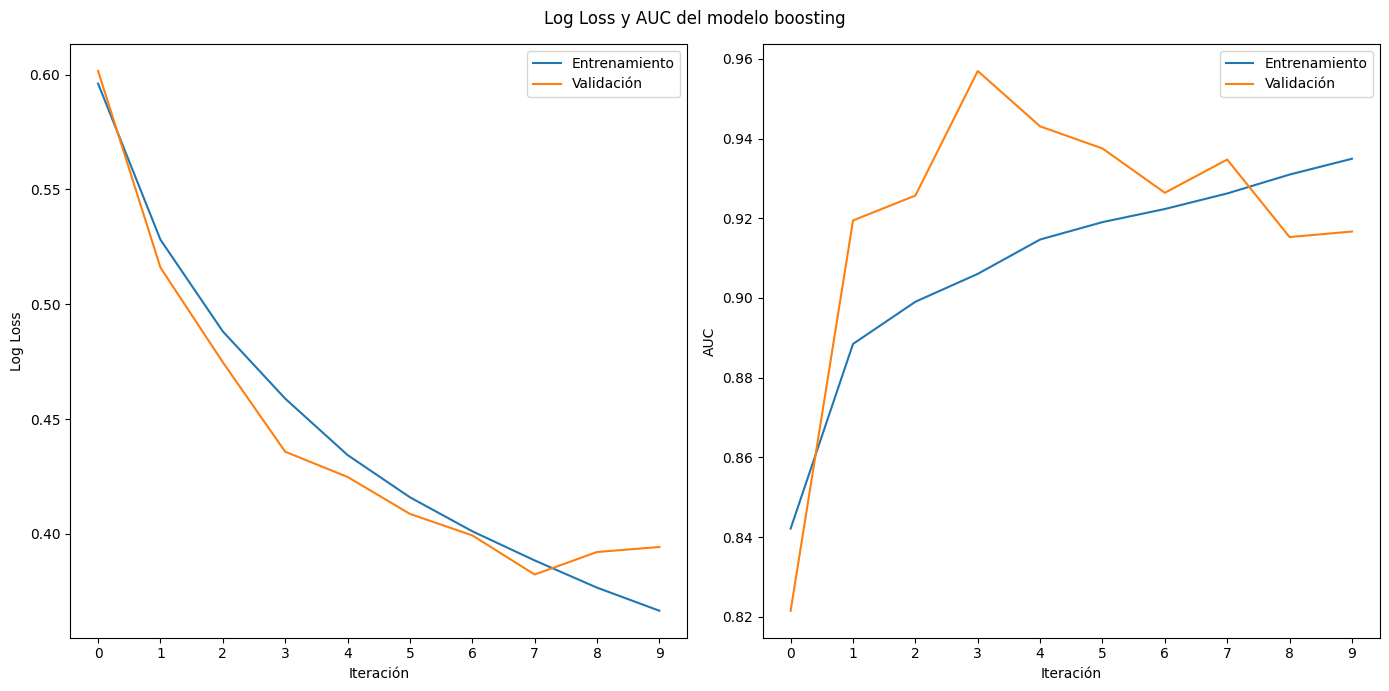

In [ ]:
# Obtener los resultados de evaluación
evals_result = model_boosting.evals_result()

# Plotear los resultados
iteraciones = len(evals_result['validation_0']['logloss'])
x_axis = range(0, iteraciones)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plotear Log Loss
ax1.plot(x_axis, evals_result['validation_1']['logloss'], label='Entrenamiento')
ax1.plot(x_axis, evals_result['validation_0']['logloss'], label='Validación')
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Log Loss')
ax1.legend()
ax1.set_xticks(x_axis)

# Plotear Error
ax2.plot(x_axis, evals_result['validation_1']['auc'], label='Entrenamiento')
ax2.plot(x_axis, evals_result['validation_0']['auc'], label='Validación')
ax2.set_xlabel('Iteración')
ax2.set_ylabel('AUC')
ax2.legend()
ax2.set_xticks(x_axis)

# Título general para la figura
fig.suptitle('Log Loss y AUC del modelo boosting')

fig.tight_layout()
# Mostrar la figura
plt.show()

Hay un poco de sobrefiteo para el final, por eso se eligirá la iteración óptima.

In [ ]:
# Obtener el número de iteración óptima
iteracion_deseada = 7

# Restaurar el modelo a esa iteración
model_boosting.set_params(n_estimators=iteracion_deseada)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=7, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

## Veamos la influencia de cada feature (columna).

In [ ]:
# Imprimir las importancias de las columnas
for name, score in zip(train_data.columns, model_boosting.feature_importances_):
    print(f"{name}: {score}")

Pregnancies: 0.08126997947692871
Glucose: 0.14356020092964172
BloodPressure: 0.07348465919494629
SkinThickness: 0.03427671268582344
Insulin: 0.3365274667739868
BMI: 0.1350807398557663
DiabetesPedigreeFunction: 0.09964696317911148
Age: 0.09615329653024673


La insulina toma una importancia destacable frente a las otras, le sigue la Glucosa y la BMI.

## Elección del threshold

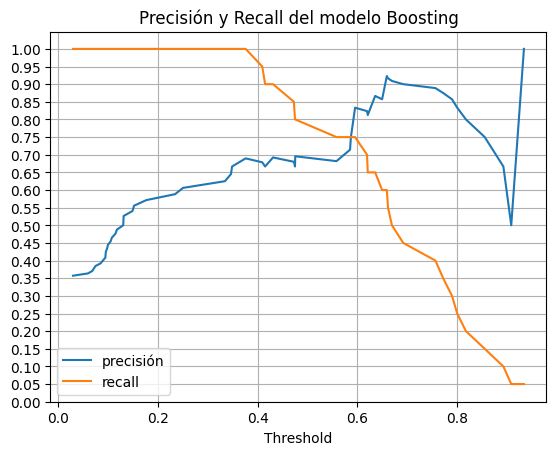

In [ ]:
y_predict_scores = model_boosting.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, y_predict_scores)

# Ploteo recall y precisión
plt.plot(thresholds, precision[:-1], label='precisión')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.yticks(np.linspace(0, 1, num=21))
plt.title('Precisión y Recall del modelo Boosting')
plt.show()

In [ ]:
threshold = thresholds[np.argmin(recall >= 0.95)]
print(f'El threshold elegido es de: {threshold:.2f} \n')

El threshold elegido es de: 0.41 



El área de la curva ROC es 0.9166666666666665


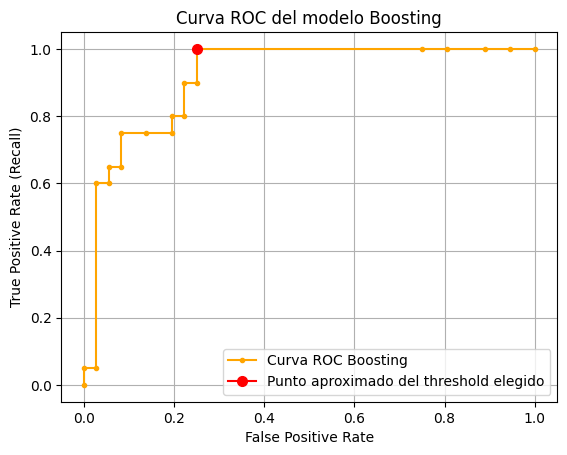

In [ ]:
# Ploteo de la Curva ROC
fper, tper, thresholds = roc_curve(y_val, y_predict_scores)
roc_auc = roc_auc_score(y_val, y_predict_scores)
plt.plot(fper, tper, marker='.', label='Curva ROC Boosting',color='orange')
plt.plot(fper[np.argmax(thresholds < threshold)],
         tper[np.argmax(thresholds < threshold)], marker='o', markersize=7,
         color='r', label='Punto aproximado del threshold elegido')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid()
print('El área de la curva ROC es', roc_auc)
plt.title('Curva ROC del modelo Boosting')
plt.show()

## Evaluación del modelo en el conjunto de testeo

In [ ]:
y_predict = model_boosting.predict_proba(X_test)[:,1]

y_predict_con_scores = (y_predict > threshold).astype(int)

print('Métricas en el conjunto de testeo:\n', classification_report(y_test, y_predict_con_scores))

Métricas en el conjunto de testeo:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82        54
           1       0.68      0.81      0.74        32

    accuracy                           0.79        86
   macro avg       0.78      0.80      0.78        86
weighted avg       0.80      0.79      0.79        86



## Matriz de Confusión

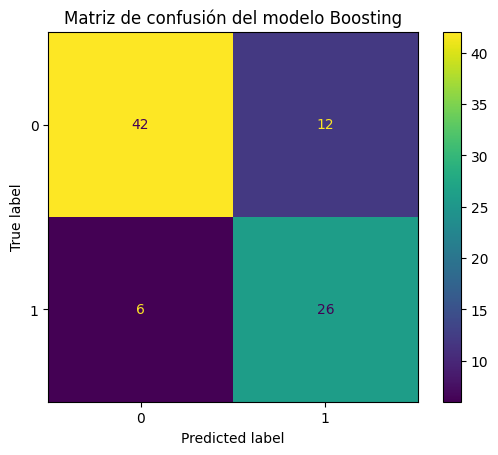

In [ ]:
cm = confusion_matrix(y_test, y_predict_con_scores)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.title('Matriz de confusión del modelo Boosting')
plt.show()

## Visualización de un árbol

In [ ]:
# Obtener el número total de árboles en el modelo
num_trees = len(model_boosting.get_booster().get_dump())
print(f"El modelo tiene {num_trees} árboles.")

El modelo tiene 10 árboles.


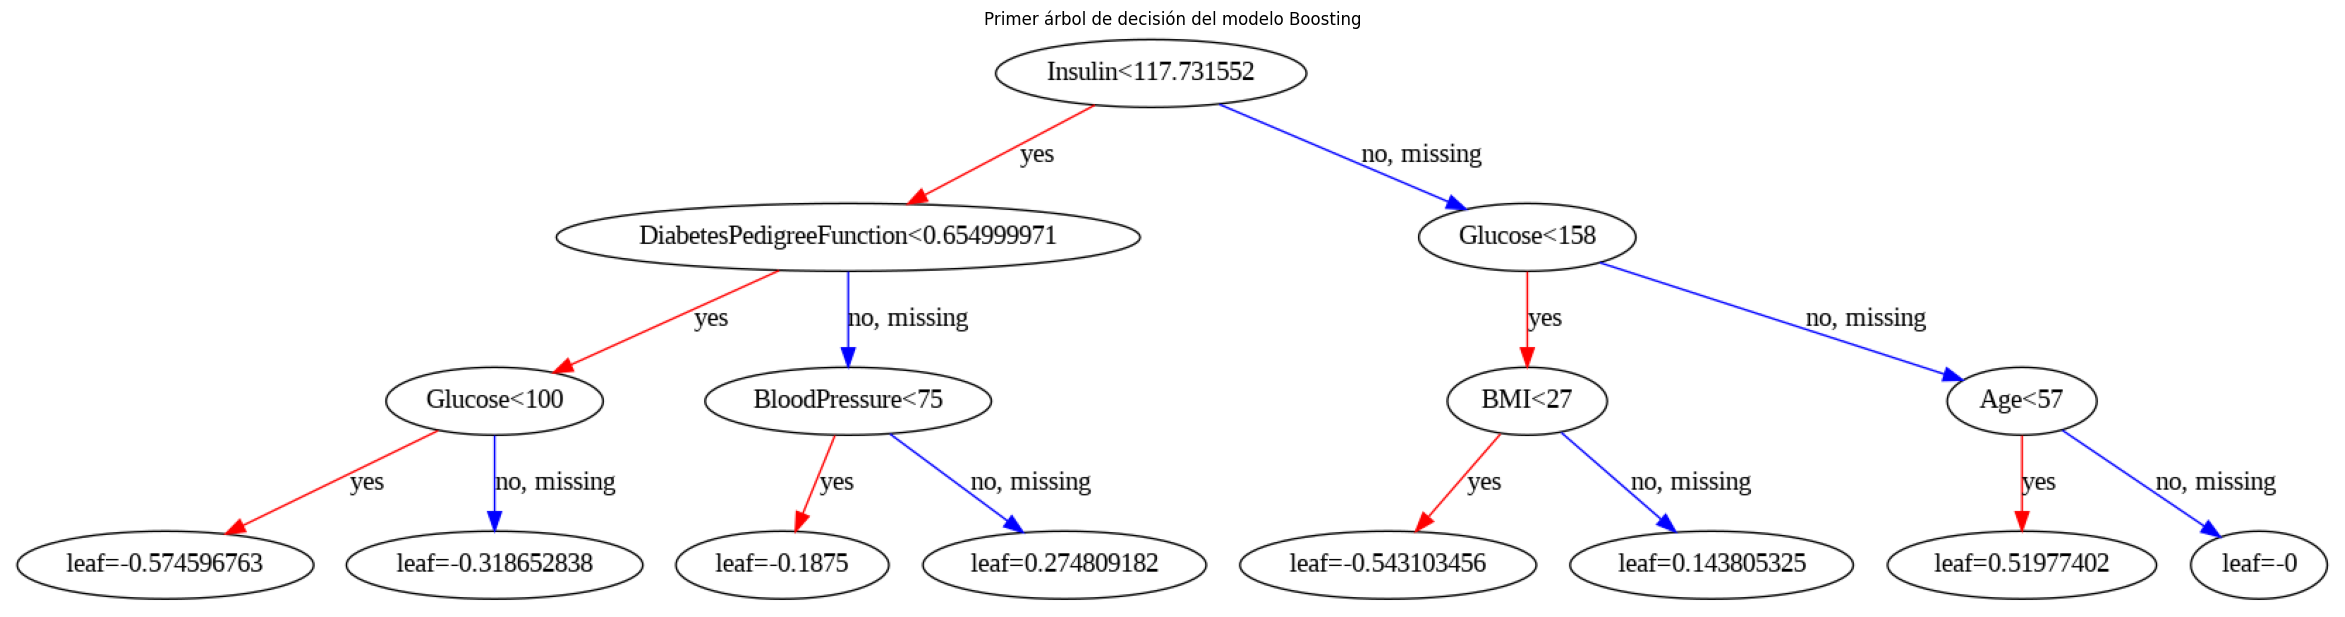

In [ ]:
num_tree = 0

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model_boosting, num_trees=num_tree, ax=ax, proportion=True)
plt.title('Primer árbol de decisión del modelo Boosting')
plt.show()

Las hojas finales son una predicción logística, para pasar a una predicción entre 0 y 1 hay que pasarla por una función, en este caso:
\begin{equation*}
f(x) = \frac{1}{1+e^{x}}
\end{equation*}
El resultado dará la probabilidad de pertenecer a la clase diabética.

### Otra forma de visualizar un árbol en específico

In [ ]:
# Paso necesario para visualizar con dtreeviz
y_train = y_train.astype(int)

viz_model = dtreeviz.model(model_boosting,
                           tree_index=num_tree,
                           X_train=X_train,
                           y_train=y_train,
                           feature_names=Scaler.feature_names_in_.tolist(),
                           target_name='Output',
                           class_names=['No diabetes', 'Diabetes'])

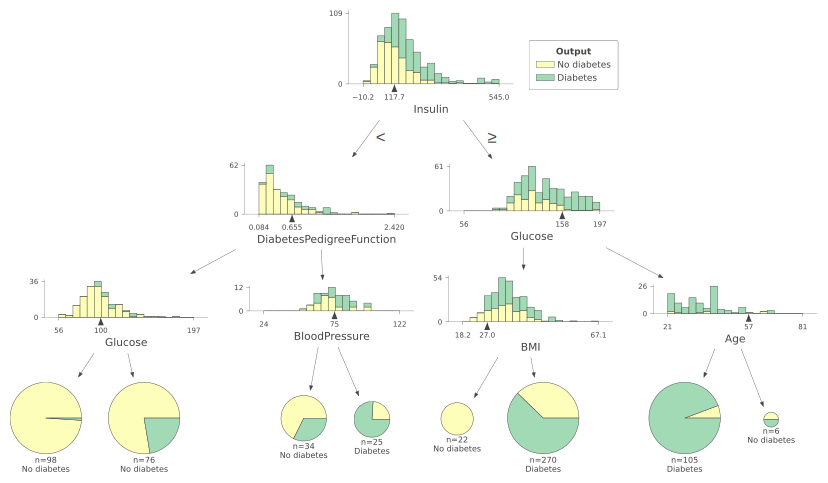

In [ ]:
# Elimina "Arial font not found warnings" que aparece al hacer la view
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
viz_model.view(scale=1.2)

# Usando SVM

## Con LinearSVC

In [ ]:
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(loss="hinge"))
    ])

# Definir la grilla de hiperparámetros
param_grid = {
    'svm_clf__C': [0.003, 0.005, 0.01, 0.03, 0.06],
    'poly_features__degree': [2, 3, 4, 5]
}
# Configurar GridSearchCV
grid_search = GridSearchCV(polynomial_svm_clf, param_grid=param_grid, scoring='roc_auc', cv=6)

grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Mejor modelo
model_SVM = grid_search.best_estimator_

Best parameters found: {'poly_features__degree': 4, 'svm_clf__C': 0.005}


### Evaluación de overfitting o underfitting

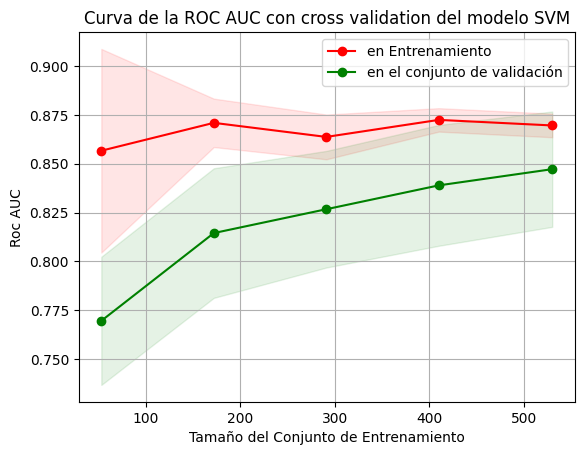

In [ ]:
# Ploteo de la roc auc con cross validation a medida que el tamaño del conjunto de entrenamiento aumenta
def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            train_sizes=train_sizes, scoring='roc_auc',
                                                            random_state=seed)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.xlabel("Tamaño del Conjunto de Entrenamiento")
    plt.ylabel("Roc AUC")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="en Entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="en el conjunto de validación")

    plt.legend(loc="best")
    return plt

# Creación del modelo de nuevo para pasarlo por la learning_curve (necesario porque hace un fit)
best_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=best_params['poly_features__degree'])),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(loss="hinge", C=best_params['svm_clf__C']))
])

plot_learning_curve(best_model, X_train, y_train, cv=6)
plt.title('Curva de la ROC AUC con cross validation del modelo SVM')
plt.show()

Se ven cómo las curvas se van acercando a medida que el tamño del conjunto de entrenamiento crece, esto es una buena señal. También los valores de AUC dan bien por lo que no habría underfitting.<br>
El modelo no está sobrefiteando.

### Veamos qué threshold elegir

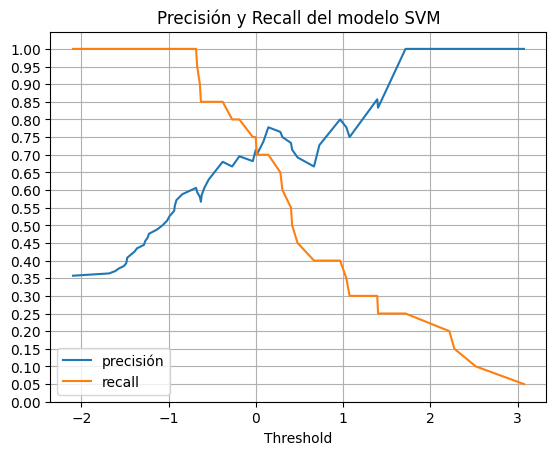

In [ ]:
y_predict_scores = model_SVM.decision_function(X_val)
precision, recall, thresholds = precision_recall_curve(y_val, y_predict_scores)

# Ploteo de la recall y precisión
plt.plot(thresholds, precision[:-1], label='precisión')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.yticks(np.linspace(0, 1, num=21))
plt.title('Precisión y Recall del modelo SVM')
plt.show()

In [ ]:
threshold = thresholds[np.argmin(recall>= 0.85)]
print(f'El threshold elegido es de: {threshold:.3f} \n')

El threshold elegido es de: -0.271 



### Curva ROC

El área de la curva ROC es 0.8763888888888889


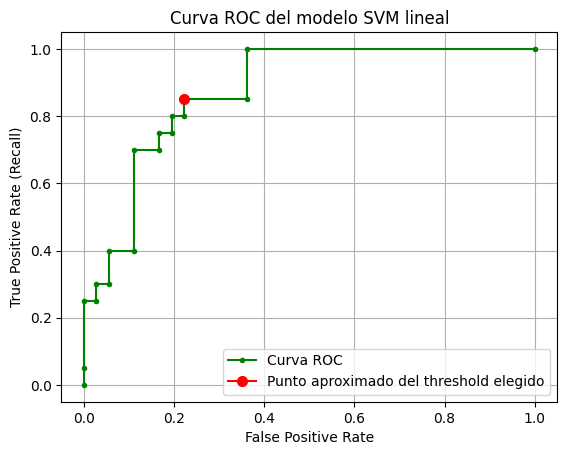

In [ ]:
fper, tper, thresholds = roc_curve(y_val, y_predict_scores)
roc_auc = roc_auc_score(y_val, y_predict_scores)

# Ploteo de la Curva ROC
plt.plot(fper, tper, marker='.', label='Curva ROC',color='g')
plt.plot(fper[np.argmax(thresholds < threshold)],
         tper[np.argmax(thresholds < threshold)], marker='o', markersize=7,
         color='r', label='Punto aproximado del threshold elegido')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid()
print('El área de la curva ROC es', roc_auc)
plt.title('Curva ROC del modelo SVM lineal')
plt.show()

### Evaluación del modelo en el conjunto de testeo

In [ ]:
y_predict_scores = model_SVM.decision_function(X_test)
y_predict_con_scores = (y_predict_scores > threshold).astype(int)
print('Métricas en el conjunto de testeo:\n', classification_report(y_test, y_predict_con_scores))

Métricas en el conjunto de testeo:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82        54
           1       0.69      0.75      0.72        32

    accuracy                           0.78        86
   macro avg       0.76      0.77      0.77        86
weighted avg       0.78      0.78      0.78        86



Buena recall en la clase diabética. Buena recall y precisión en la clase no diabética.

## Con kernel RBF

In [ ]:
# tubería que incluye el escalado de características y el SVM con kernel RBF
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])

# Definir un rango de hiperparámetros para búsqueda en cuadrícula
param_grid = {
    'svm__C': [0.1, 1, 5, 10, 15],
    'svm__gamma': [0, 0.1, 0.01, 1e-3, 1e-4]
}

# Configurar GridSearchCV para encontrar los mejores hiperparámetros
grid_search_svm_rbf = GridSearchCV(pipeline, param_grid, cv=6, scoring='roc_auc', n_jobs=-1)

# Ajustar el modelo
grid_search_svm_rbf.fit(X_train, y_train)

best_params = grid_search_svm_rbf.best_params_
# Imprimir los mejores hiperparámetros encontrados
print(f"Mejores parámetros: {best_params}")

Mejores parámetros: {'svm__C': 1, 'svm__gamma': 0.1}


In [ ]:
# Mejor modelo
model_SVM_rbf = grid_search_svm_rbf.best_estimator_

### Evaluación de overfitting o underfitting

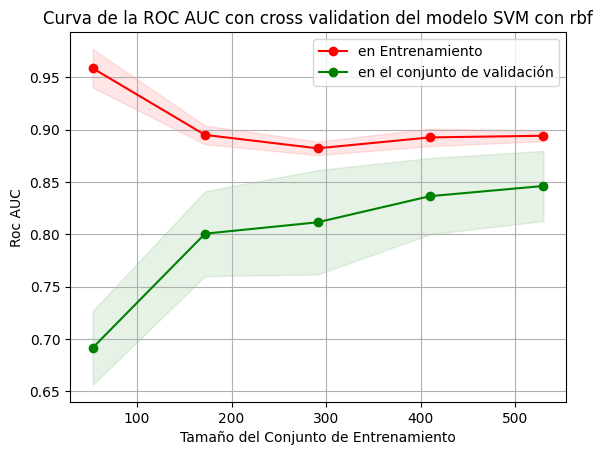

In [ ]:
# Creación del modelo de nuevo para pasarlo por la learning_curve (necesario porque hace un fit)
pipeline_best = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, C=best_params['svm__C'], gamma=best_params['svm__gamma']))
])

plot_learning_curve(pipeline_best, X_train, y_train, cv=6)
plt.title('Curva de la ROC AUC con cross validation del modelo SVM con rbf')
plt.show()

Las curvas se acercan lo cual indica que no hay sobrefiteo. También los valores de AUC dan bien por lo que no habría underfitting. <br>
El modelo está bien.

### Veamos qué threshold elegir

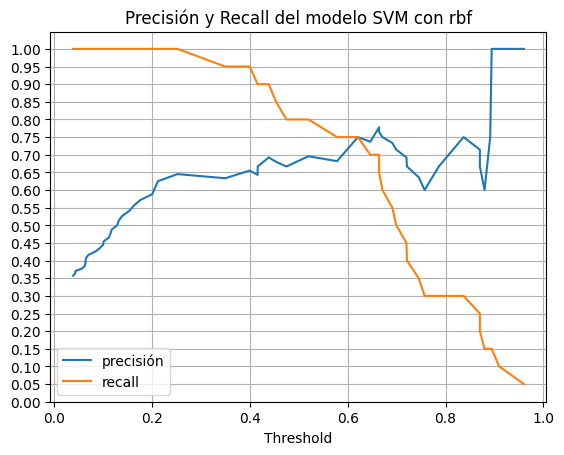

In [ ]:
y_predict_scores = model_SVM_rbf.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, y_predict_scores)

# Ploteo de la recall y precisión
plt.plot(thresholds, precision[:-1], label='precisión')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.yticks(np.linspace(0, 1, num=21))
plt.title('Precisión y Recall del modelo SVM con rbf')
plt.show()

In [ ]:
threshold = thresholds[np.argmin(recall>= 0.9)]
print(f'El threshold elegido es de: {threshold:.3f} \n')

El threshold elegido es de: 0.453 



### Curva ROC

El área de la curva ROC es 0.8791666666666667


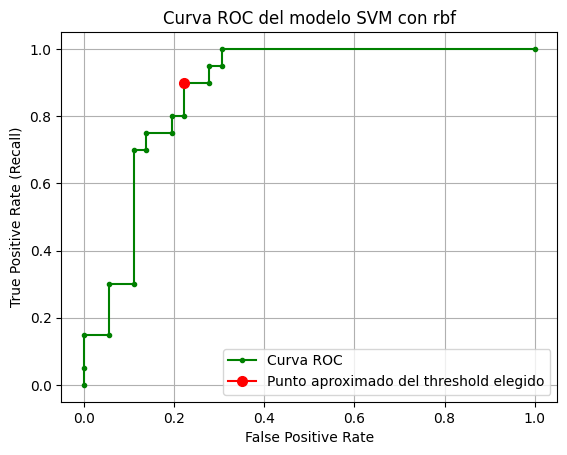

In [ ]:
fper, tper, thresholds = roc_curve(y_val, y_predict_scores)
roc_auc = roc_auc_score(y_val, y_predict_scores)

# Ploteo de la Curva ROC
plt.plot(fper, tper, marker='.', label='Curva ROC',color='g')
plt.plot(fper[np.argmax(thresholds < threshold)],
         tper[np.argmax(thresholds < threshold)], marker='o', markersize=7,
         color='r', label='Punto aproximado del threshold elegido')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid()
print('El área de la curva ROC es', roc_auc)
plt.title('Curva ROC del modelo SVM con rbf')
plt.show()

### Evaluación del modelo en el conjunto de testeo

In [ ]:
y_predict_scores = model_SVM_rbf.predict_proba(X_test)[:,1]
y_predict_con_scores = (y_predict_scores > threshold).astype(int)
print('Métricas en el conjunto de testeo:\n', classification_report(y_test, y_predict_con_scores))

Métricas en el conjunto de testeo:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81        54
           1       0.67      0.75      0.71        32

    accuracy                           0.77        86
   macro avg       0.75      0.76      0.76        86
weighted avg       0.78      0.77      0.77        86



Buena recall (en la clase de diabéticas) a costo de que baja la precisión.

# Con regresión logística

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LogisticRegression(random_state=seed))
  ])

# Definir el espacio de búsqueda
param_grid = {
    'svm__C': [0.003, 0.005, 0.01, 0.1, 1],
    'svm__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'svm__solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'svm__max_iter': [4, 5, 6, 8, 10]
}

# Configurar GridSearchCV para encontrar los mejores hiperparámetros
grid_search_logistic_reg = GridSearchCV(pipeline, param_grid, cv=8, scoring='roc_auc', n_jobs=-1)

# Ajustar el modelo
grid_search_logistic_reg.fit(X_train, y_train)

best_params = grid_search_logistic_reg.best_params_

# Imprimir los mejores hiperparámetros encontrados
print(f"Mejores parámetros: {best_params}")

Mejores parámetros: {'svm__C': 0.003, 'svm__max_iter': 5, 'svm__penalty': 'none', 'svm__solver': 'lbfgs'}


In [ ]:
# Mejor modelo
model_regresion_logistica = grid_search_logistic_reg.best_estimator_

## Ver si hay underfitting o overfitting

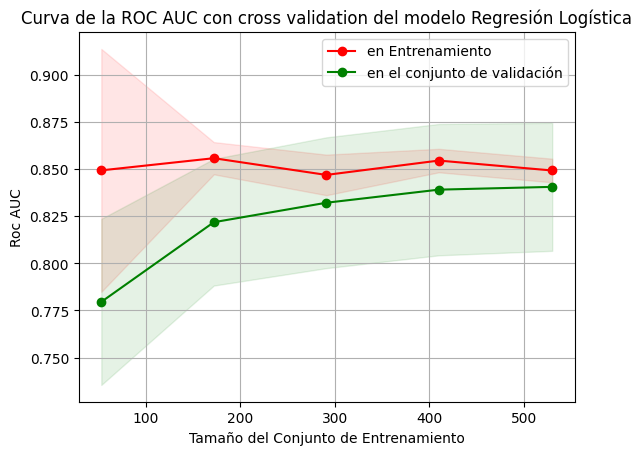

In [ ]:
# Creación del modelo de nuevo para pasarlo por la learning_curve (necesario porque hace un fit)
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LogisticRegression(random_state=seed, C=best_params['svm__C'], penalty=best_params['svm__penalty'],
                               solver=best_params['svm__solver'], max_iter=best_params['svm__max_iter']))
  ])

plot_learning_curve(best_pipeline, X_train, y_train, cv=6)
plt.title('Curva de la ROC AUC con cross validation del modelo Regresión Logística')
plt.show()

Las curvas se acercan y buena valor de AUC. No hay overfitting ni underfitting.

## Hagamos una k-fold Cross Validation para ver la performance del modelo

In [ ]:
# Creación del modelo de nuevo para pasarlo por cross validation (necesario porque hace un fit)
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LogisticRegression(random_state=seed, C=best_params['svm__C'], penalty=best_params['svm__penalty'],
                               solver=best_params['svm__solver'], max_iter=best_params['svm__max_iter']))
  ])

n_splits = 6
scoring = ['accuracy', 'f1', 'precision', 'recall']
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
scores = cross_validate(best_pipeline, X_train,
                        y_train, cv=kfold, scoring=scoring)

for j in range(n_splits):
  print('Iteración %i: Accuracy %.2f, f1_score %.2f, precisión %.2f y recall %.2f' % (j+1, scores['test_accuracy'][j],
                                                                                      scores['test_f1'][j],
                                                                                      scores['test_precision'][j],
                                                                                      scores['test_recall'][j]))
print("""Medias del promedio (desvío):
  Accuracy %.2f%% (%.2f%%),
  f1_score %.2f%% (%.2f%%),
  precisión %.2f%% (%.2f%%) y
  recall %.2f%% (%.2f%%)\n""" % (
      scores['test_accuracy'].mean()*100, scores['test_accuracy'].std()*100,
      scores['test_f1'].mean()*100, scores['test_f1'].std()*100,
      scores['test_precision'].mean()*100, scores['test_precision'].std()*100 ,
      scores['test_recall'].mean()*100, scores['test_recall'].std()*100))

Iteración 1: Accuracy 0.68, f1_score 0.67, precisión 0.69 y recall 0.66
Iteración 2: Accuracy 0.77, f1_score 0.79, precisión 0.75 y recall 0.83
Iteración 3: Accuracy 0.72, f1_score 0.67, precisión 0.79 y recall 0.58
Iteración 4: Accuracy 0.78, f1_score 0.77, precisión 0.81 y recall 0.74
Iteración 5: Accuracy 0.80, f1_score 0.80, precisión 0.82 y recall 0.77
Iteración 6: Accuracy 0.80, f1_score 0.80, precisión 0.81 y recall 0.79
Medias del promedio (desvío):
  Accuracy 75.94% (4.58%),
  f1_score 75.02% (5.49%),
  precisión 77.79% (4.76%) y
  recall 72.96% (8.34%)



## Veamos qué threshold elegir

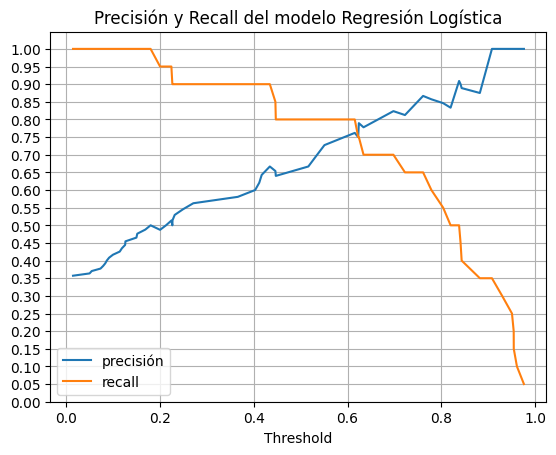

In [ ]:
y_predict_scores = model_regresion_logistica.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, y_predict_scores)

# Ploteo de la recall y precisión
plt.plot(thresholds, precision[:-1], label='precisión')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.yticks(np.linspace(0, 1, num=21))
plt.title('Precisión y Recall del modelo Regresión Logística')
plt.show()

In [ ]:
threshold = thresholds[np.argmin(recall>= 0.9)]
print(f'El threshold elegido es de: {threshold:.2f} \n')

El threshold elegido es de: 0.45 



## Curva ROC

El área de la curva ROC es 0.8930555555555555


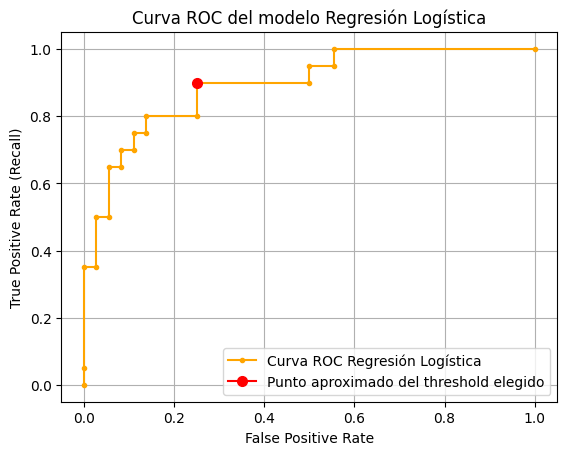

In [ ]:
fper, tper, thresholds = roc_curve(y_val, y_predict_scores)
roc_auc = roc_auc_score(y_val, y_predict_scores)

# Ploteo de la curva ROC
plt.plot(fper, tper, marker='.', label='Curva ROC Regresión Logística', color='orange')
plt.plot(fper[np.argmax(thresholds < threshold)],
         tper[np.argmax(thresholds < threshold)], marker='o', markersize=7,
         color='r', label='Punto aproximado del threshold elegido')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid()
print('El área de la curva ROC es', roc_auc)
plt.title('Curva ROC del modelo Regresión Logística')
plt.show()

## Evaluación del modelo en el conjunto de testeo

In [ ]:
y_predict_scores = model_regresion_logistica.predict_proba(X_test)[:,1]
y_predict_con_scores = (y_predict_scores > threshold).astype(int)
print('Métricas en el conjunto de testeo:\n', classification_report(y_test, y_predict_con_scores))

Métricas en el conjunto de testeo:
               precision    recall  f1-score   support

           0       0.86      0.81      0.84        54
           1       0.71      0.78      0.75        32

    accuracy                           0.80        86
   macro avg       0.79      0.80      0.79        86
weighted avg       0.81      0.80      0.80        86



Buena recall y precisión en ambas clases.

# Con Ensamble (Votting Classifier)

In [ ]:
# pipeline para la red neuronal
pipeline_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', model_red_neuronal)
])

In [ ]:
# Según se recomienda, en un ensamble de modelos se recomienda aplicar tantos como clases haya (en este caso 2)
voting_clf = VotingClassifier(estimators=[
        #('nn_clf', pipeline_nn),
        #('svm_rbf', model_SVM_rbf),
        ('xgb', model_boosting),
        ('log', model_regresion_logistica)
    ], voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None, n_estimators=7,
                                            n_jobs=-1, num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('log',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svm',
                                               LogisticRegression(C=0.003,
                                                                  max_iter=5,
                                                                  penalty='none',
                                                                  random_state=42))]))],
                 voting='soft')

## Evaluación si hay overfitting o underfitting

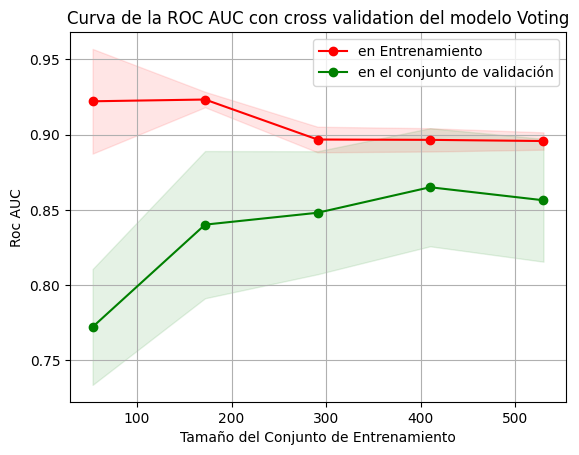

In [ ]:
# Creación del modelo de nuevo para pasarlo por la learning_curve (necesario porque hace un fit)
voting = VotingClassifier(estimators=[
        #('nn_clf', pipeline_nn),
        #('svm_rbf', model_SVM_rbf),
        ('xgb', model_boosting),
        ('log', model_regresion_logistica)
    ], voting='soft')

plot_learning_curve(voting, X_train, y_train, cv=6)
plt.title('Curva de la ROC AUC con cross validation del modelo Voting')
plt.show()

Las curvas se acercan y se obtiene un buen valor de AUC. El modelo está bien.

## Evaluación de métricas y elección de threshold

In [ ]:
# Creación del modelo de nuevo para pasarlo por una cross validation (necesario porque hace un fit)
voting = VotingClassifier(estimators=[
        #('nn_clf', pipeline_nn),
        #('svm_rbf', model_SVM_rbf),
        ('xgb', model_boosting),
        ('log', model_regresion_logistica)
    ], voting='soft')

scoring = ['roc_auc', 'accuracy', 'recall', 'precision']
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=seed)
scores = cross_validate(voting , X_train, y_train, scoring=scoring, cv=cv, verbose=0)
print(f'ROC AUC: {scores["test_roc_auc"].mean():.3f} +/- {scores["test_roc_auc"].std():.3f}')
print(f'Accuracy: {scores["test_accuracy"].mean():.3f} +/- {scores["test_accuracy"].std():.3f}')
print(f'Recall: {scores["test_recall"].mean():.3f} +/- {scores["test_recall"].std():.3f}')
print(f'Precision: {scores["test_precision"].mean():.3f} +/- {scores["test_precision"].std():.3f}')

ROC AUC: 0.864 +/- 0.039
Accuracy: 0.774 +/- 0.033
Recall: 0.792 +/- 0.079
Precision: 0.767 +/- 0.041


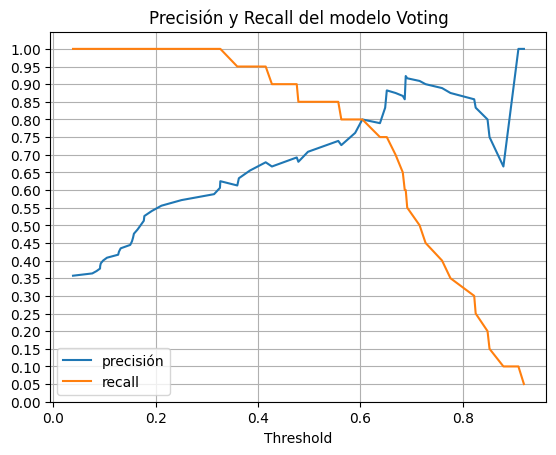

In [ ]:
prob = voting_clf.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, prob)

# Ploteo de la recall y precisión
plt.plot(thresholds, precision[:-1], label='precisión')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.yticks(np.linspace(0, 1, num=21))
plt.title('Precisión y Recall del modelo Voting')
plt.show()

In [ ]:
# Threshold elegido
threshold = thresholds[np.argmin(recall >= 0.9)]
print(f'El threshold elegido es de: {threshold:.2f} \n')

El threshold elegido es de: 0.48 



## Curva ROC

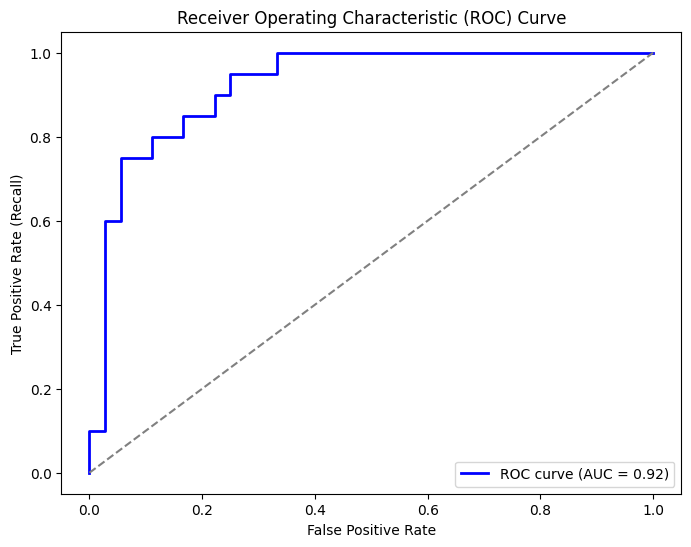

In [ ]:
# Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
fpr, tpr, thresholds = roc_curve(y_val, prob)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_val, prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Evaluación en el conjunto de testeo

In [ ]:
predictions = (voting_clf.predict_proba(X_test)[:,1] > threshold).astype(int)
print('Métricas en el conjunto de testeo:\n', classification_report(y_test, predictions))

Métricas en el conjunto de testeo:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84        54
           1       0.74      0.72      0.73        32

    accuracy                           0.80        86
   macro avg       0.79      0.79      0.79        86
weighted avg       0.80      0.80      0.80        86



Balanceado modelo con respecto a la recall y precisión.

# Conclusión

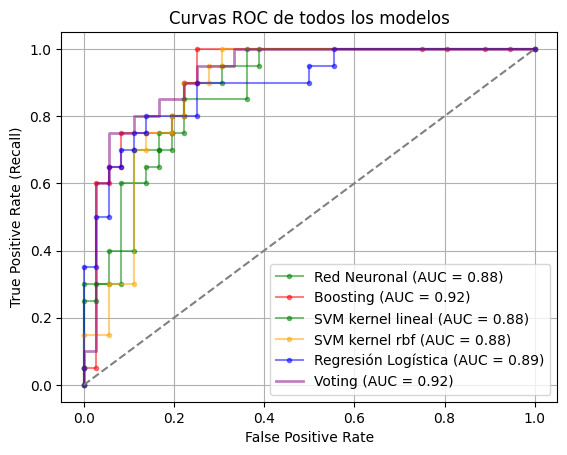

In [ ]:
# Redes Neuronales
y_predict_scores = model_red_neuronal.predict_proba(X_val_escalado)[:,1]
fpr, tper, thresholds = roc_curve(y_val, y_predict_scores)
roc_auc = roc_auc_score(y_val, y_predict_scores)
plt.plot(fpr, tper, marker='.', label='Red Neuronal (AUC = %0.2f)' % roc_auc, color='g', alpha=0.5)

# Boosting
y_predict_scores = model_boosting.predict_proba(X_val)[:,1]
fpr, tper, thresholds = roc_curve(y_val, y_predict_scores)
roc_auc = roc_auc_score(y_val, y_predict_scores)
plt.plot(fpr, tper, marker='.', label='Boosting (AUC = %0.2f)' % roc_auc, color='r', alpha=0.5)

# SVM con kernel lineal
y_predict_scores = model_SVM.decision_function(X_val)
fper, tper, thresholds = roc_curve(y_val, y_predict_scores)
roc_auc = roc_auc_score(y_val, y_predict_scores)
plt.plot(fper, tper, marker='.', label='SVM kernel lineal (AUC = %0.2f)' % roc_auc, color='g', alpha=0.5)

# SVM con kernel rbf
y_predict_scores = model_SVM_rbf.predict_proba(X_val)[:,1]
fper, tper, thresholds = roc_curve(y_val, y_predict_scores)
roc_auc = roc_auc_score(y_val, y_predict_scores)
plt.plot(fper, tper, marker='.', label='SVM kernel rbf (AUC = %0.2f)' % roc_auc, color='orange', alpha=0.5)

# Regresión logística
y_predict_scores = model_regresion_logistica.predict_proba(X_val)[:,1]
fper, tper, thresholds = roc_curve(y_val, y_predict_scores)
roc_auc = roc_auc_score(y_val, y_predict_scores)
plt.plot(fper, tper, marker='.', label='Regresión Logística (AUC = %0.2f)' % roc_auc ,color='blue', alpha=0.5)

# Voting
y_predict_scores = voting_clf.predict_proba(X_val)[:,1]
fpr, tper, thresholds = roc_curve(y_val, prob)
roc_auc = roc_auc_score(y_val, prob)
plt.plot(fpr, tper, color='purple', lw=2, label='Voting (AUC = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curvas ROC de todos los modelos')
plt.legend()
plt.grid()
plt.show()


In [ ]:
results = {
    'Model': ['Red Neuronal', 'Boosting', 'SVM lineal', 'SVM rbf', 'Regresión Logística', 'Ensamble (Votting)'],
    'Precisión': [0.68, 0.68, 0.69, 0.67, 0.71, 0.74],
    'Recall': [0.78, 0.81, 0.75, 0.75, 0.78, 0.72]
}

df = pd.DataFrame(results)

print(df.to_string())

                 Model  Precisión  Recall
0         Red Neuronal       0.68    0.78
1             Boosting       0.68    0.81
2           SVM lineal       0.69    0.75
3              SVM rbf       0.67    0.75
4  Regresión Logística       0.71    0.78
5   Ensamble (Votting)       0.74    0.72


Los resultados utilizando diferentes modelos no dan tanta diferencia pero se podría destacar el ensamble (Votting Classifier) y el boosting al obtener los mejores resultados en cuanto a Roc Auc. Uno esperaría que el ensamble generalice mejor al utilizar 2 modelos diferentes. <br>
Cabe aclarar que el proyecto se basaba más en explorar diferentes modelos y jugar con diferentes técnicas e hiperparámetros, no así tanto en centrarse en mejorar los modelos al máximo.